## Neural Netowrks

In [ ]:
import tensorflow as tf         # Detecting GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew, boxcox
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_df=pd.read_csv("train.csv")

In [5]:
train_df

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,DRIRC89L0T,18,137576,209136,846,26,2,10.47,60,0.81,High School,Self-employed,Single,Yes,No,Business,No,0
1,TS0FIUNHNU,47,57194,5970,748,30,2,19.72,36,0.73,High School,Unemployed,Divorced,No,Yes,Education,No,0
2,I0YR284A1V,26,84328,95065,453,7,2,24.25,12,0.45,Master's,Self-employed,Married,No,No,Other,Yes,0
3,WB1T7NQV8A,53,49795,229582,533,107,3,14.44,60,0.17,Bachelor's,Self-employed,Single,Yes,No,Auto,Yes,1
4,J6GU9M4G1Z,49,115450,22072,840,0,4,24.48,12,0.11,Bachelor's,Part-time,Single,No,Yes,Education,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204272,KYS1HKNGGE,40,116623,161673,651,79,2,23.44,12,0.87,Bachelor's,Part-time,Divorced,No,No,Home,Yes,0
204273,5MAOH3AOZO,67,62958,189499,460,77,3,9.29,36,0.11,Bachelor's,Self-employed,Single,No,No,Business,Yes,0
204274,5Y9Z6NW29X,62,34372,59645,524,94,3,9.72,60,0.24,PhD,Full-time,Single,Yes,No,Auto,No,0
204275,O51974F566,44,146262,198454,489,7,4,4.31,48,0.30,High School,Self-employed,Married,Yes,No,Home,No,0


In [6]:
train_df.drop_duplicates(inplace=True)  #dropping duplicates(if any)

In [7]:
train_df.shape

(204277, 18)

In [8]:
print(train_df.isnull() .sum()) #checking for null values

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64


In [9]:
train_df.drop('LoanID', axis=1, inplace=True)     #dropping unnecessary columns

In [10]:
print(len(pd.unique(train_df['Education'])))
print(len(pd.unique(train_df['EmploymentType'])))
print(len(pd.unique(train_df['MaritalStatus'])))
print(len(pd.unique(train_df['LoanPurpose'])))

4
4
3
5


In [ ]:
le = LabelEncoder()         # converting to numerical values using Label Encoding

for col in ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose', 'HasMortgage', 'HasDependents', 'HasCoSigner']:
    train_df[col] = le.fit_transform(train_df[col])

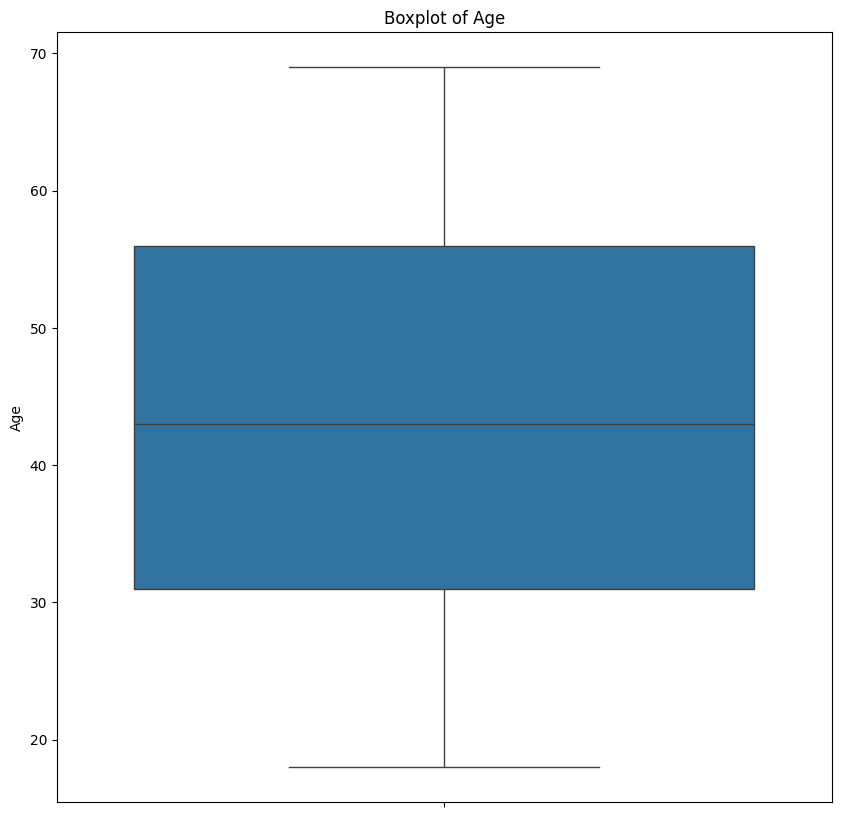

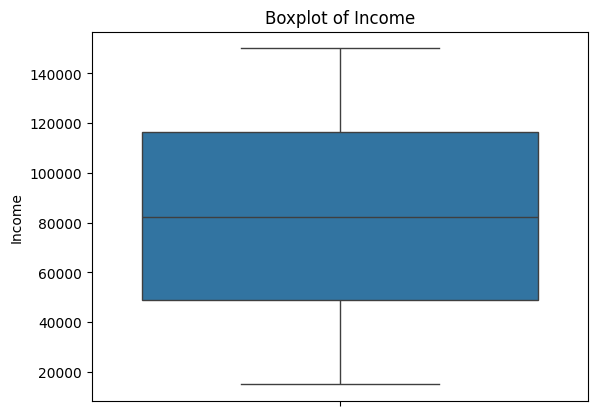

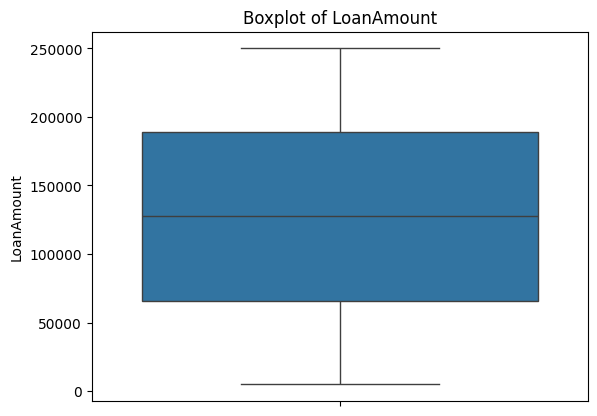

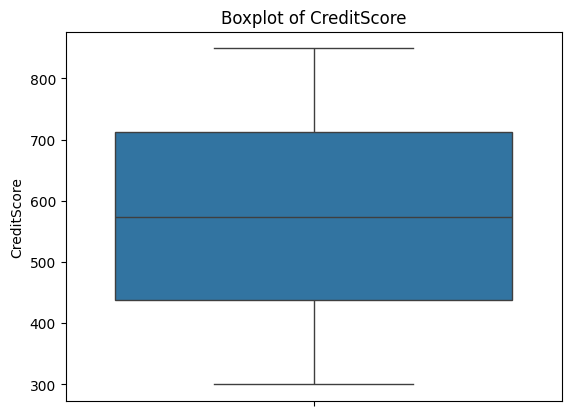

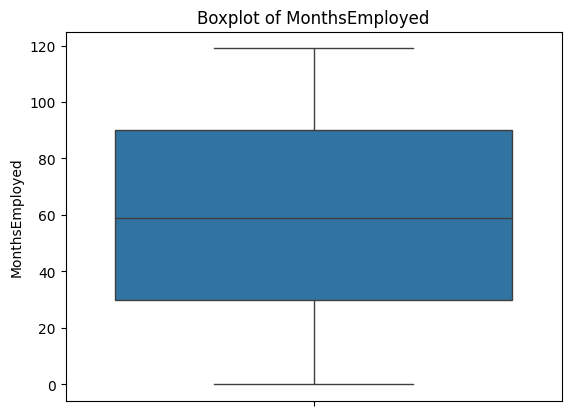

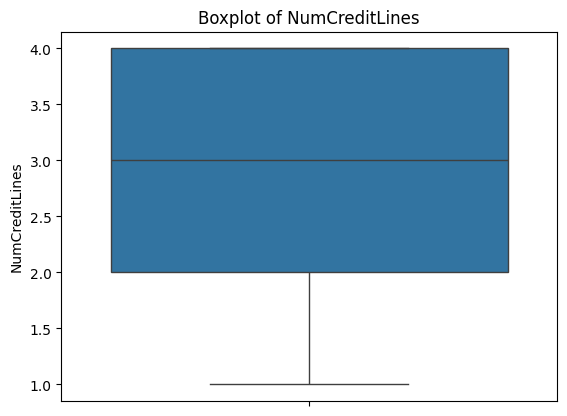

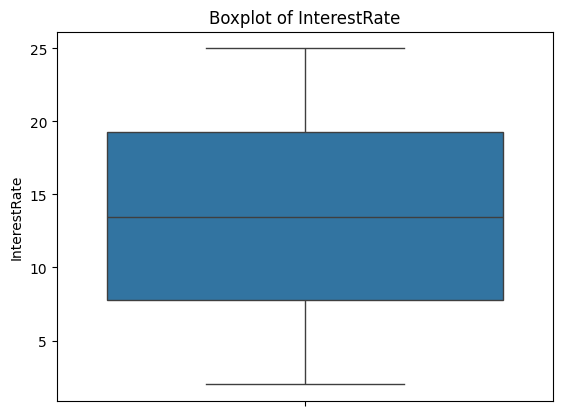

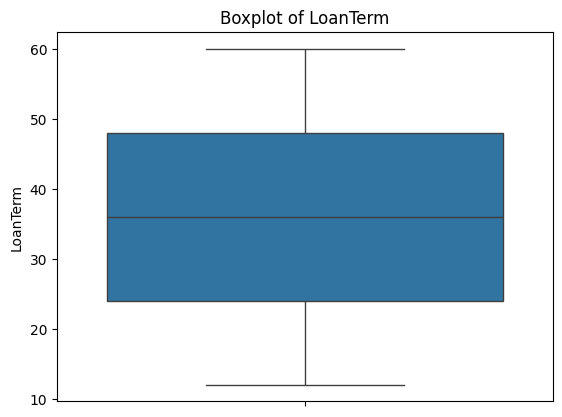

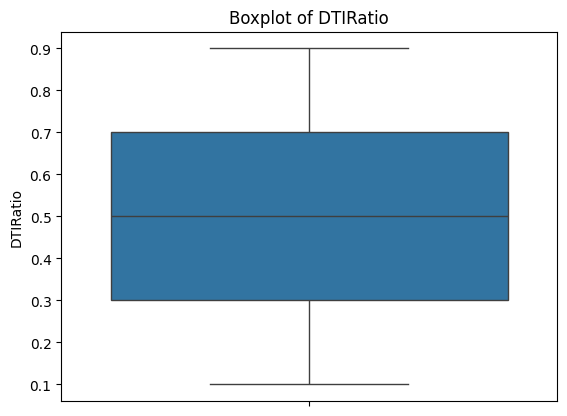

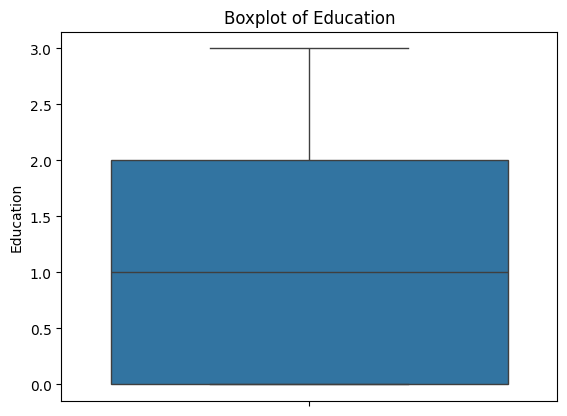

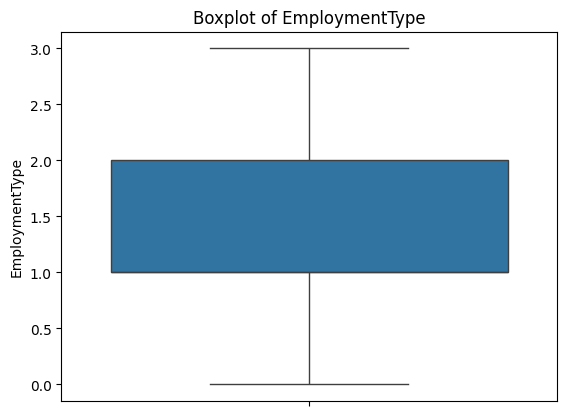

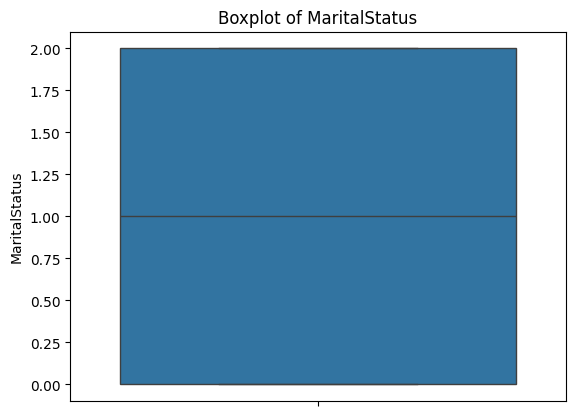

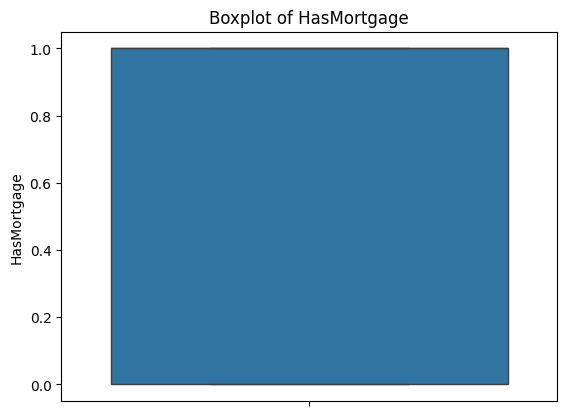

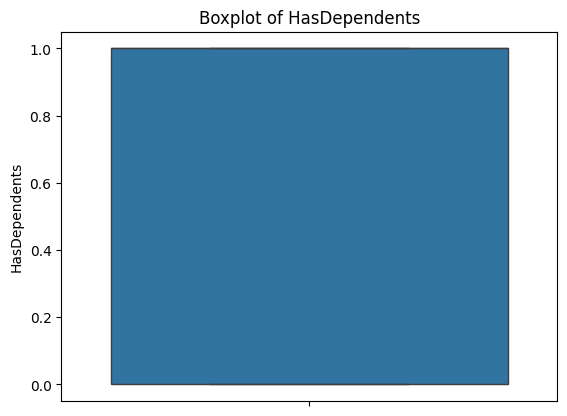

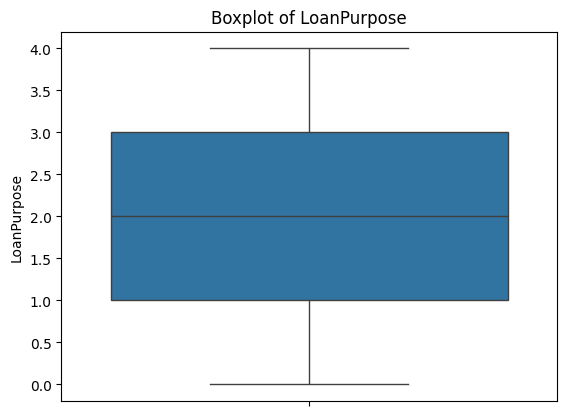

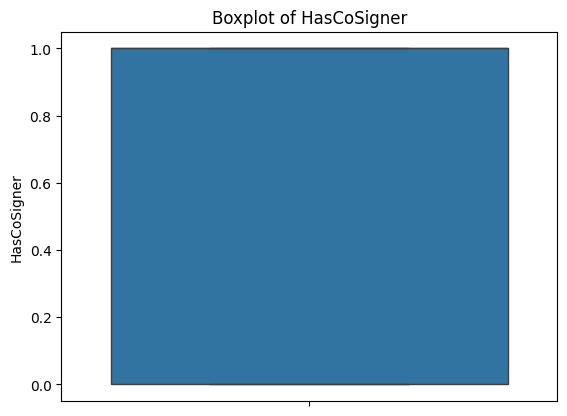

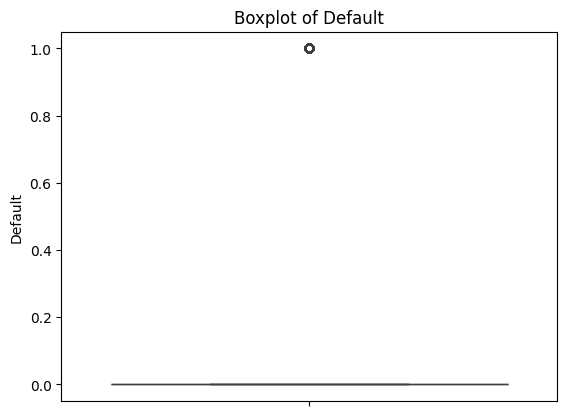

In [ ]:
#Checking for Outliers

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))

for column in train_df.columns:
  if train_df[column].dtype != 'object':
    sns.boxplot(train_df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

In [ ]:
# Spliting data into training and testing sets

X = train_df.drop('Default', axis=1)
y = train_df['Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51) # 80% train, 20% test

In [ ]:
# Bayesian Optimization for Hyperparameter Tuning

  !pip install keras-tuner
  import tensorflow as tf
  from tensorflow import keras
  from kerastuner.tuners import BayesianOptimization
  from kerastuner.engine.hyperparameters import HyperParameters

  def build_model(hp):
      model = keras.Sequential()
      model.add(keras.layers.Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                                  activation='relu', input_shape=(X_train.shape[1],)))
      for i in range(hp.Int('num_layers', 1, 3)):
          model.add(keras.layers.Dense(units=hp.Int(f'units_{i+2}', min_value=32, max_value=512, step=32),
                                      activation='relu'))
      model.add(keras.layers.Dense(1, activation='sigmoid'))  
      model.compile(
          optimizer=keras.optimizers.Adam(
              hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
          loss='binary_crossentropy',
          metrics=['accuracy'])
      return model

  tuner = BayesianOptimization(
      build_model,
      objective='val_accuracy',
      max_trials=10,  
      executions_per_trial=2, 
      directory='my_dir',
      project_name='intro_to_kt')

  tuner.search(x=X_train, y=y_train, epochs=10, validation_data=(X_test,y_test))

  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

  print(f"""
  The hyperparameter search is complete. The optimal number of units in the first densely-connected
  layer is {best_hps.get('units_1')}, in the second layer is {best_hps.get('units_2')} and the optimal learning rate for the optimizer
  is {best_hps.get('learning_rate')}.
  """)


# Training the model with best parameters found above

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

eval_result = model.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

Trial 10 Complete [00h 04m 34s]
val_accuracy: 0.8853289484977722

Best val_accuracy So Far: 0.8854268491268158
Total elapsed time: 00h 52m 22s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 128, in the second layer is 288 and the optimal learning rate for the optimizer
is 0.0001.

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4086/4086 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.7980 - loss: 50.8748 - val_accuracy: 0.8855 - val_loss: 10.6825
Epoch 2/50
4086/4086 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8045 - loss: 23.9302 - val_accuracy: 0.8340 - val_loss: 7.3250
Epoch 3/50
4086/4086 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7998 - loss: 17.4185 - val_accuracy: 0.8854 - val_loss: 31.3737
Epoch 4/50
4086/4086 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8035 - loss: 11.6698 - val_accuracy: 0.6049 - val_loss: 4.3434
Epoch 5/50
4086/4086 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8007 - loss: 8.2261 - val_accuracy: 0.8854 - val_loss: 6.1486
Epoch 6/50
4086/4086 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8050 - loss: 5.7862 - val_accuracy: 0.3283 - val_loss: 3.7733
Epoch 7/50
4086/4086 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8043 - loss: 3.6193 - val_accuracy: 0.8854 - val_loss: 1.6016
Epoch 8/50
4086/4086 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8060 - loss: 2.3307 - va

In [ ]:
# Dowloading the model for future use

model.save('my_model.keras')  

from google.colab import files
files.download('my_model.keras') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
test_df=pd.read_csv("test.csv")

In [ ]:
le = LabelEncoder()     # PreProcessing on test data

for col in ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose', 'HasMortgage', 'HasDependents', 'HasCoSigner']:
    test_df[col] = le.fit_transform(test_df[col])

In [23]:
test_df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,CKV34LU7V7,55,112656,92393,581,113,2,23.54,36,0.15,3,2,2,1,1,3,0
1,62KTYNH93J,56,91569,131575,641,54,1,15.19,12,0.43,1,1,0,1,1,2,1
2,JGFUSOIUH7,26,78169,75417,569,105,3,18.02,12,0.29,2,1,1,1,1,2,1
3,4538THBHOX,26,63033,10804,326,118,1,14.71,24,0.41,1,1,2,0,0,1,1
4,DXLNA06JHR,24,29665,21182,662,102,3,15.02,60,0.69,3,3,2,0,1,1,1


In [24]:
y_train = train_df['Default']
X_train = train_df.drop('Default', axis=1)
X_test = test_df.drop('LoanID', axis=1)

In [ ]:
import numpy as np
y_pred_prob = model.predict(X_test)

y_pred = (y_pred_prob > 0.5).astype(int)    # Setting threshold as 0.5 -- above 0.5 converted to 1
y_pred = np.squeeze(y_pred) # Removing single-dimensional entries from the shape

submission_df = pd.DataFrame({'LoanID': test_df['LoanID'],
                              'Default': y_pred})

from google.colab import files
submission_df.to_csv('submission.csv', index=False)
files.download('submission.csv')

1596/1596 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Removing Skewness using SMOTE

---



In [ ]:
train_df=pd.read_csv("train.csv")

In [ ]:
train_df.drop('LoanID', axis=1, inplace=True)    

In [ ]:
le = LabelEncoder()

for col in ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose', 'HasMortgage', 'HasDependents', 'HasCoSigner']:
    train_df[col] = le.fit_transform(train_df[col])

In [78]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
# Checking class distribution of "Default"
class_counts = train_df['Default'].value_counts()
print("Class distribution before SMOTE:")
print(class_counts)

Class distribution before SMOTE:
Default
0    180524
1     23753
Name: count, dtype: int64


In [ ]:
print(skew(train_df['Default']))    #Checking skew value

2.394081993720339


In [ ]:

X = train_df.drop('Default', axis=1)  # Features
y = train_df['Default']              # Target

smote = SMOTE(random_state=51)

# Resampling the data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check new class distribution
print("Class distribution after SMOTE:")
print(Counter(y_resampled))

Class distribution after SMOTE:
Counter({0: 180524, 1: 180524})


In [ ]:
print(skew(y_resampled))    # Skewness reduced to 0

0.0


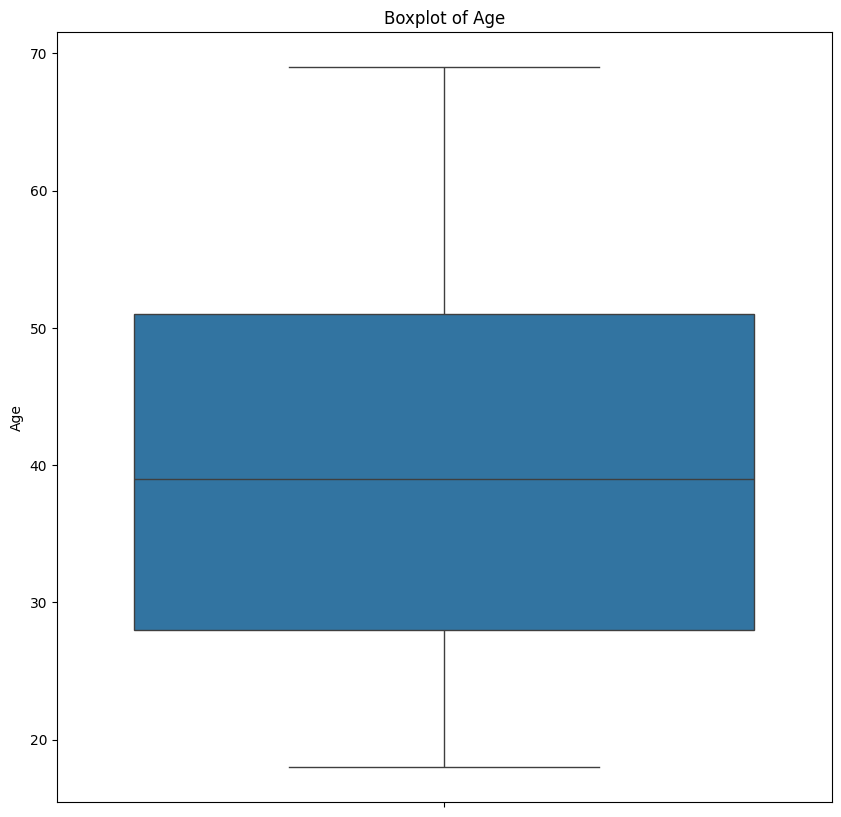

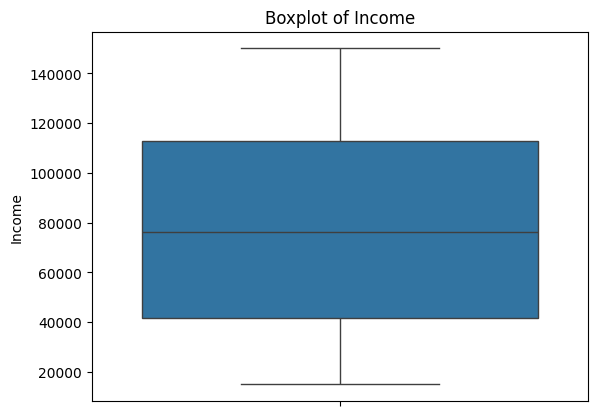

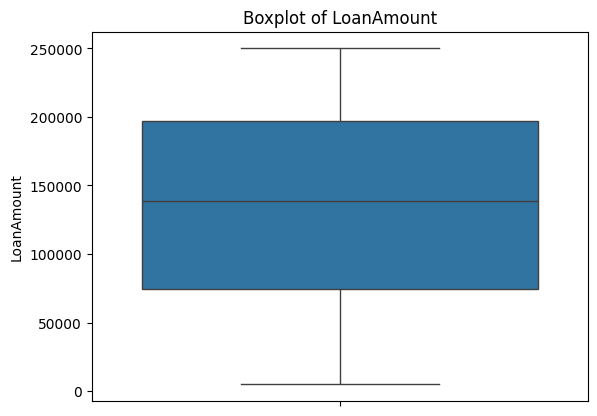

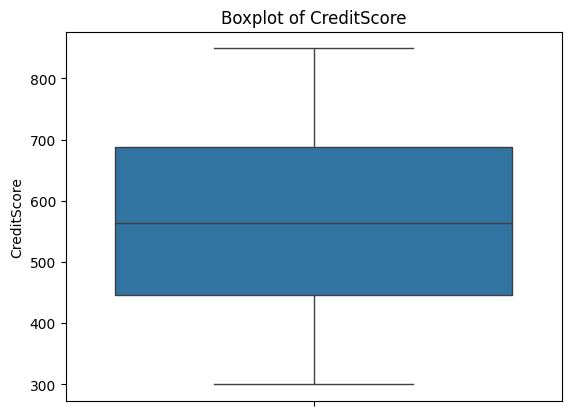

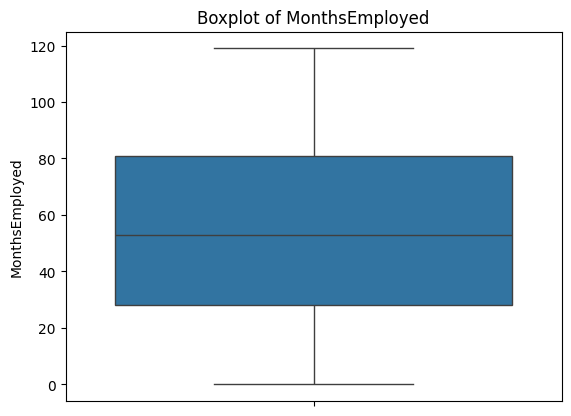

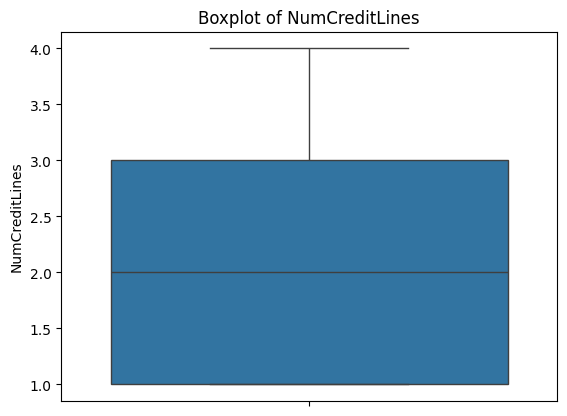

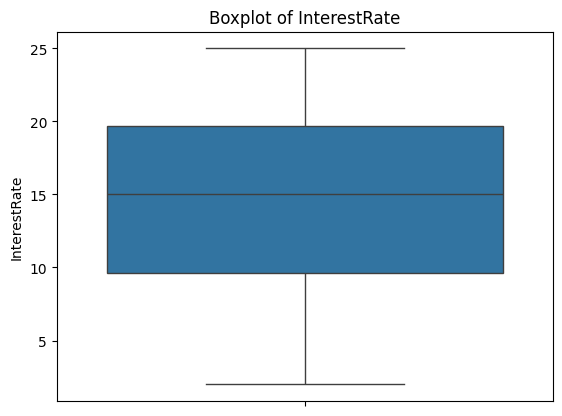

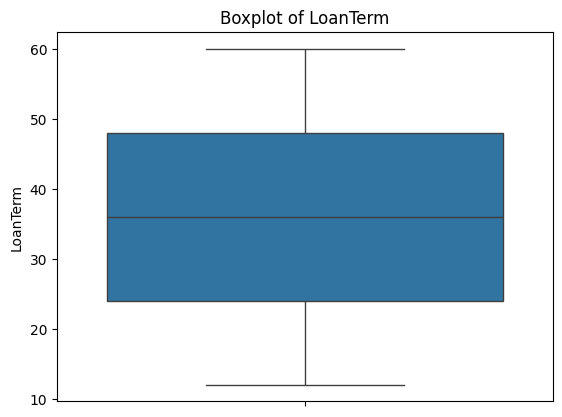

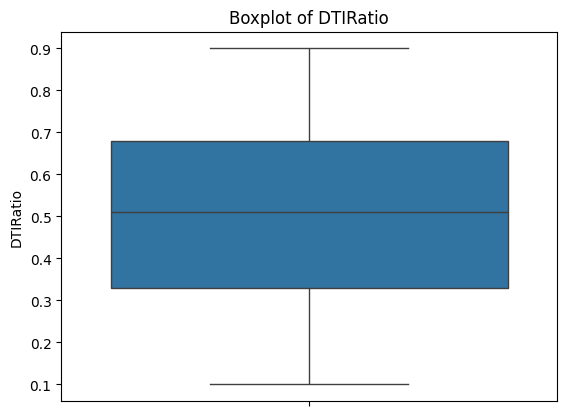

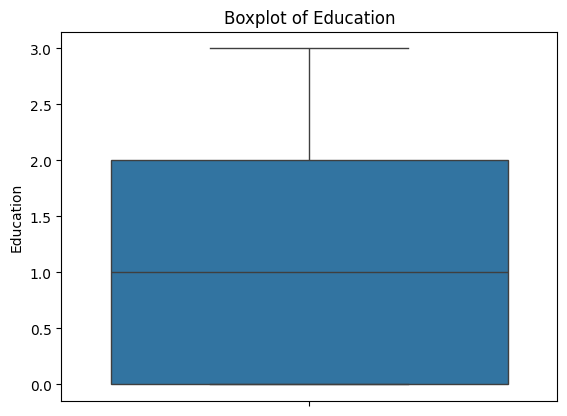

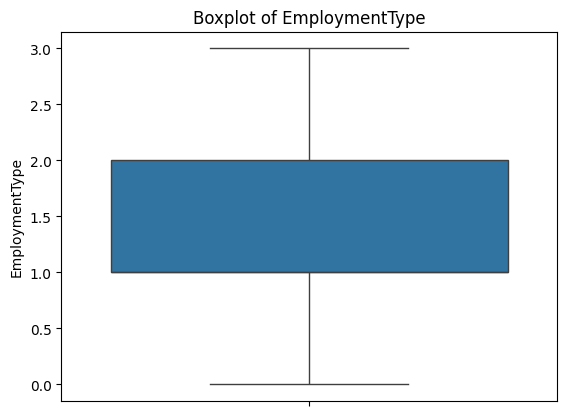

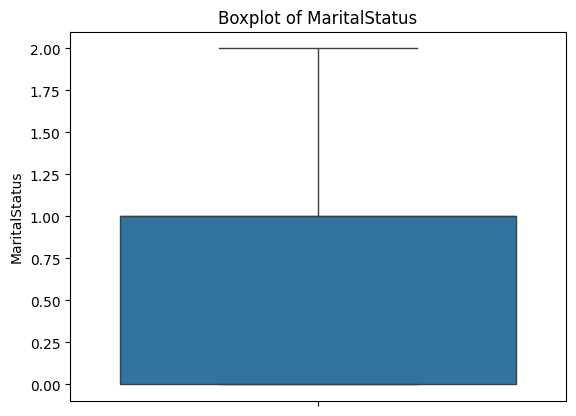

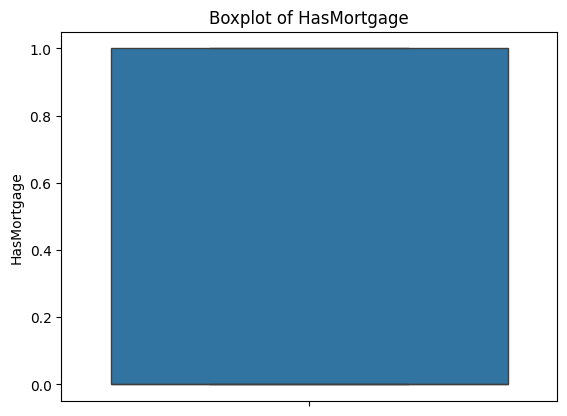

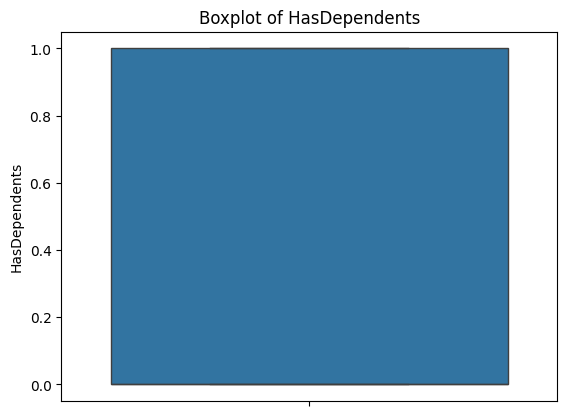

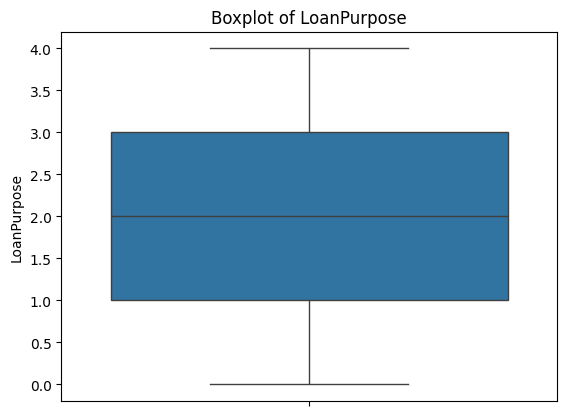

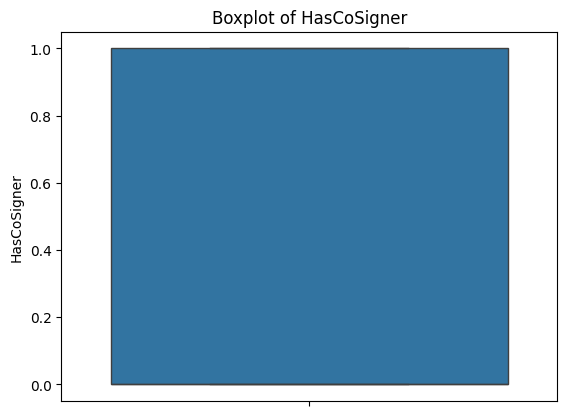

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))

for column in X_resampled.columns:
  if X_resampled[column].dtype != 'object':
    sns.boxplot(X_resampled[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=51) # 80% train, 20% test

In [ ]:

# Finding new hyperparameters for the data

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32),
                                 activation='relu', input_shape=(X_train.shape[1],)))
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(keras.layers.Dense(units=hp.Int(f'units_{i+2}', min_value=32, max_value=512, step=32),
                                     activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,  
    executions_per_trial=1, 
    directory='my_dir_2',
    project_name='intro_to_kt')

tuner.search(x=X_train, y=y_train, epochs=8, validation_data=(X_test,y_test))

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_1')}, in the second layer is {best_hps.get('units_2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Trial 5 Complete [00h 03m 20s]
val_accuracy: 0.642694890499115

Best val_accuracy So Far: 0.6752527356147766
Total elapsed time: 00h 18m 02s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 448, in the second layer is 224 and the optimal learning rate for the optimizer
is 0.0001.



In [ ]:
# Training the model with the best parameters found above

model_2 = tuner.hypermodel.build(best_hps)
history = model_2.fit(X_train, y_train, epochs=50, validation_split=0.2)

eval_result = model_2.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7221/7221 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.5330 - loss: 108.6645 - val_accuracy: 0.5133 - val_loss: 63.5835
Epoch 2/50
7221/7221 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5507 - loss: 53.2121 - val_accuracy: 0.5420 - val_loss: 41.2264
Epoch 3/50
7221/7221 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5583 - loss: 45.6762 - val_accuracy: 0.6370 - val_loss: 16.9277
Epoch 4/50
7221/7221 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.5736 - loss: 38.4998 - val_accuracy: 0.6103 - val_loss: 27.8290
Epoch 5/50
7221/7221 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5890 - loss: 28.6887 - val_accuracy: 0.6044 - val_loss: 17.3542
Epoch 6/50
7221/7221 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5949 - loss: 26.2433 - val_accuracy: 0.6209 - val_loss: 8.5408
Epoch 7/50
7221/7221 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.5985 - loss: 24.4179 - val_accuracy: 0.6277 - val_loss: 11.5755
Epoch 8/50
7221/7221 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.6101 - loss

In [ ]:
# downloading the model for future use

model.save('my_model_2.keras')

from google.colab import files
files.download('my_model_2.keras') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [90]:
test_df=pd.read_csv("test.csv")

In [91]:
le = LabelEncoder()

for col in ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose', 'HasMortgage', 'HasDependents', 'HasCoSigner']:
    test_df[col] = le.fit_transform(test_df[col])

In [92]:
test_df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,CKV34LU7V7,55,112656,92393,581,113,2,23.54,36,0.15,3,2,2,1,1,3,0
1,62KTYNH93J,56,91569,131575,641,54,1,15.19,12,0.43,1,1,0,1,1,2,1
2,JGFUSOIUH7,26,78169,75417,569,105,3,18.02,12,0.29,2,1,1,1,1,2,1
3,4538THBHOX,26,63033,10804,326,118,1,14.71,24,0.41,1,1,2,0,0,1,1
4,DXLNA06JHR,24,29665,21182,662,102,3,15.02,60,0.69,3,3,2,0,1,1,1


In [93]:
y_train = train_df['Default']
X_train = train_df.drop('Default', axis=1)
X_test = test_df.drop('LoanID', axis=1)

In [ ]:
import numpy as np
y_pred_prob = model_2.predict(X_test)

y_pred = (y_pred_prob > 0.5).astype(int)
y_pred = np.squeeze(y_pred) 

submission_df = pd.DataFrame({'LoanID': test_df['LoanID'],
                              'Default': y_pred})

from google.colab import files
submission_df.to_csv('submission_2.csv', index=False)
files.download('submission_2.csv')

1596/1596 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>